In [1]:
from tqdm import tqdm
import pickle
from irt import *
from selection import *
from utils import *

random_state = 42

Definitions

In [2]:
scenarios = {'boolq:':['boolq:'],
             #'civil_comments':['civil_comments:demographic=LGBTQ,',
             #                  'civil_comments:demographic=all,',
             #                  'civil_comments:demographic=black,',
             #                  'civil_comments:demographic=christian,',
             #                  'civil_comments:demographic=female,',
             #                  'civil_comments:demographic=male,',
             #                  'civil_comments:demographic=muslim,',
             #                  'civil_comments:demographic=other_religions,',
             #                  'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             'narrative_qa:':['narrative_qa:'],
             'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            
scenarios_metrics = {'boolq:':'em', 
                     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':'em',
                     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':'em',
                     'imdb:':'em', 
                     'mmlu':'em', 
                     'msmarco:track=regular,valid_topk=30,':'RR@10', 
                     'msmarco:track=trec,valid_topk=30,':'NDCG@10', 
                     'narrative_qa:':'f1', 
                     'natural_qa:mode=closedbook,':'f1', 
                     'natural_qa:mode=openbook_longans,':'f1', 
                     'quac:':'f1', 
                     'raft':'em', 
                     'truthful_qa:task=mc_single,method=multiple_choice_joint,':'em'}

## Data

Loading data

In [3]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)

## Results

In [4]:
dropout = .5 #default .5
hidden = 100 #default 100
epochs = 2000 #default 2000
lr = .1 #default .1
device = 'cuda'
balance = True

num_elements = 4
iterations = 10
number_items = [10, 25, 50, 75, 100]
Ds = [5, 10, 15, 20, 25, 30]
set_of_rows = create_sublists_corrected(list(range(len(data['models']))), num_elements)
set_of_rows

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19],
 [20, 21, 22, 23],
 [24, 25, 26, 27]]

### Predicting accuracy

### Prep data
scenarios_position, subscenarios_position = prepare_data(scenarios_choosen, scenarios, data)
scores = create_responses(scenarios_choosen, scenarios, data)
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
responses_train = np.zeros(scores_train.shape)
responses_test = np.zeros(scores_test.shape)

cs = np.linspace(0.01,.99,1000)
for scenario in scenarios.keys():
    ind = scenarios_position[scenario]
    c = cs[np.argmin([np.mean((np.abs((scores_train[:,ind]>c).mean(axis=1)-scores_train[:,ind].mean(axis=1)))) for c in cs])]
    responses_train[:,ind] = (scores_train[:,ind]>c).astype(int)
    responses_test[:,ind] = (scores_test[:,ind]>c).astype(int)
    print(c, np.abs(responses_train[:,ind].mean(axis=1)-scores_train[:,ind].mean(axis=1)).mean(), np.abs(responses_test[:,ind].mean(axis=1)-scores_test[:,ind].mean(axis=1)).mean())   

  0%|                                                                           | 0/7 [00:00<?, ?it/s]

[04:54:18] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-0:1:2:3_scenario-full_val_al cli.py:111
           l_models3.jsonlines                                                  
           output directory: models/irt_helm/rows-0:1:2:3_D-5_scenari cli.py:112
           o-full_val_all_models3/                                              
[04:54:18] amortized: False                                       dataset.py:112
[04:54:19] Vocab size: None                                       training.py:90
[04:54:19] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[05:04:55] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 845889.9311 │ 845889.9311 │ 0.1000 │
│ 101   │ 193549.6479 │ 191195.8737 │ 0.0990 │
│ 201   │ 269801.9479 │ 123261.9073

[05:15:53] Vocab size: None                                       training.py:90
[05:15:53] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           15, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1973204.4356 │ 1973204.4356 │ 0.1000 │
│ 101   │ 228131.5701  │ 197929.1359  │ 0.0990 │
│ 201   │ 201092.8738  │ 

 14%|█████████                                                      | 1/7 [44:35<4:27:30, 2675.12s/it]

[05:38:58] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-4:5:6:7_scenario-full_val_al cli.py:111
           l_models3.jsonlines                                                  
           output directory: models/irt_helm/rows-4:5:6:7_D-5_scenari cli.py:112
           o-full_val_all_models3/                                              
[05:38:58] amortized: False                                       dataset.py:112
[05:38:59] Vocab size: None                                       training.py:90
[05:38:59] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[05:43:49] Vocab size: None                                       training.py:90
[05:43:49] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 937975.9109 │ 937975.9109 │ 0.1000 │
│ 101   │ 188147.2841 │ 159672.5057 │ 0.0990 │
│ 201   │ 338875.0576 │ 127336.0247

[05:52:02] Vocab size: None                                       training.py:90
[05:52:02] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           30, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1760681.6570 │ 1760681.6570 │ 0.1000 │
│ 101   │ 621756.0164  │ 308386.6505  │ 0.0990 │
│ 201   │ 242272.4779  │ 

 29%|█████████████████▍                                           | 2/7 [2:15:19<5:58:41, 4304.28s/it]

[07:09:39] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-8:9:10:11_scenario-full_val_ cli.py:111
           all_models3.jsonlines                                                
           output directory: models/irt_helm/rows-8:9:10:11_D-5_scena cli.py:112
           rio-full_val_all_models3/                                            
[07:09:39] amortized: False                                       dataset.py:112
[07:09:40] Vocab size: None                                       training.py:90
[07:09:40] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[07:13:49] Vocab size: None                                       training.py:90
[07:13:49] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 694376.7881 │ 694376.7881 │ 0.1000 │
│ 101   │ 304875.7542 │ 159755.2896 │ 0.0990 │
│ 201   │ 134933.1071 │ 124466.6832

[07:18:48] Vocab size: None                                       training.py:90
[07:18:48] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           25, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1424154.3917 │ 1424154.3917 │ 0.1000 │
│ 101   │ 357837.1335  │ 298111.1846  │ 0.0990 │
│ 201   │ 207099.5621  │ 

 43%|██████████████████████████▏                                  | 3/7 [3:12:24<4:20:10, 3902.54s/it]

[08:06:44] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-12:13:14:15_scenario-full_va cli.py:111
           l_all_models3.jsonlines                                              
           output directory: models/irt_helm/rows-12:13:14:15_D-5_sce cli.py:112
           nario-full_val_all_models3/                                          
[08:06:44] amortized: False                                       dataset.py:112
[08:06:44] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[08:11:03] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 2062573.5697 │ 2062573.5697 │ 0.1000 │
│ 101   │ 264238.2052  │ 181820.1745  │ 0.0990 │
│ 201   │ 164028.3923  │ 

[08:16:07] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           15, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 855915.8649 │ 855915.8649 │ 0.1000 │
│ 101   │ 460071.6870 │ 204013.6567 │ 0.0990 │
│ 201   │ 364921.2956 │ 177465.1244

 57%|██████████████████████████████████▊                          | 4/7 [3:44:03<2:35:34, 3111.48s/it]

[08:38:23] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-16:17:18:19_scenario-full_va cli.py:111
           l_all_models3.jsonlines                                              
           output directory: models/irt_helm/rows-16:17:18:19_D-5_sce cli.py:112
           nario-full_val_all_models3/                                          
[08:38:23] amortized: False                                       dataset.py:112
[08:38:23] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[08:42:52] Vocab size: None                                       training.py:90
[08:42:52] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 998977.7181 │ 998977.7181 │ 0.1000 │
│ 101   │ 203117.5936 │ 176130.4879 │ 0.0990 │
│ 201   │ 200688.9523 │ 127505.3918

[08:48:09] Vocab size: None                                       training.py:90
[08:48:09] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           30, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1715947.5576 │ 1715947.5576 │ 0.1000 │
│ 101   │ 386252.5817  │ 303845.8462  │ 0.0990 │
│ 201   │ 238516.6847  │ 

 71%|███████████████████████████████████████████▌                 | 5/7 [4:56:34<1:58:37, 3558.67s/it]

[09:50:54] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-20:21:22:23_scenario-full_va cli.py:111
           l_all_models3.jsonlines                                              
           output directory: models/irt_helm/rows-20:21:22:23_D-5_sce cli.py:112
           nario-full_val_all_models3/                                          
[09:50:54] amortized: False                                       dataset.py:112
[09:50:54] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[09:55:17] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 779129.9703 │ 779129.9703 │ 0.1000 │
│ 101   │ 244585.0107 │ 165296.1371 │ 0.0990 │
│ 201   │ 157364.4129 │ 125737.0144

[10:00:19] Vocab size: None                                       training.py:90
[10:00:19] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1189148.7196 │ 1189148.7196 │ 0.1000 │
│ 101   │ 626892.9647  │ 216594.8594  │ 0.0990 │
│ 201   │ 232310.2525  │ 

 86%|██████████████████████████████████████████████████████         | 6/7 [5:36:17<52:38, 3158.87s/it]

[10:30:37] config: model_type='multidim_2pl' epochs=2000 priors=None  cli.py:109
           initializers=[] dims=5 lr=0.1 lr_decay=0.9999 dropout=0.5            
           hidden=100 vocab_size=None log_every=100 seed=None                   
           deterministic=False                                                  
           data_path: data/irt_helm/rows-24:25:26:27_scenario-full_va cli.py:111
           l_all_models3.jsonlines                                              
           output directory: models/irt_helm/rows-24:25:26:27_D-5_sce cli.py:112
           nario-full_val_all_models3/                                          
[10:30:37] amortized: False                                       dataset.py:112
[10:30:37] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 1

[10:36:05] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 12}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 12, 'priors': 'vague', 'dims':                 
           20, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([115440]) torch.Size([115440])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss        ┃ Best Loss   ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 858961.0131 │ 858961.0131 │ 0.1000 │
│ 101   │ 272720.1024 │ 200385.5791 │ 0.0990 │
│ 201   │ 157653.2648 │ 106549.1866

[10:43:26] Vocab size: None                                       training.py:90
[10:43:26] Training Model...                                          cli.py:116
           args: {'device': 'cuda', 'num_items': 9620,           training.py:134
           'num_subjects': 24}                                                  
           Parsed Model Args: {'device': 'cuda', 'num_items':    training.py:147
           9620, 'num_subjects': 24, 'priors': 'vague', 'dims':                 
           30, 'dropout': 0.5, 'hidden': 100, 'vocab_size':                     
           None}                                                                
torch.Size([230880]) torch.Size([230880])
Training Pyro IRT Model for 2000 epochs
┏━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Epoch ┃ Loss         ┃ Best Loss    ┃ New LR ┃
┡━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 1     │ 1363376.7645 │ 1363376.7645 │ 0.1000 │
│ 101   │ 331911.5607  │ 316133.1332  │ 0.0990 │
│ 201   │ 255206.0285  │ 

100%|███████████████████████████████████████████████████████████████| 7/7 [6:55:32<00:00, 3561.76s/it]


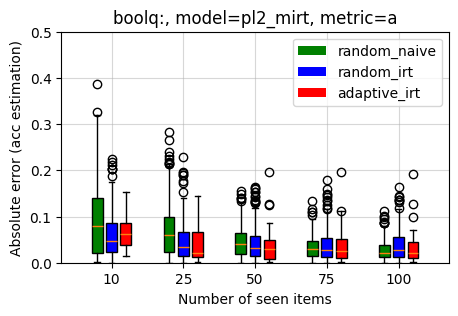

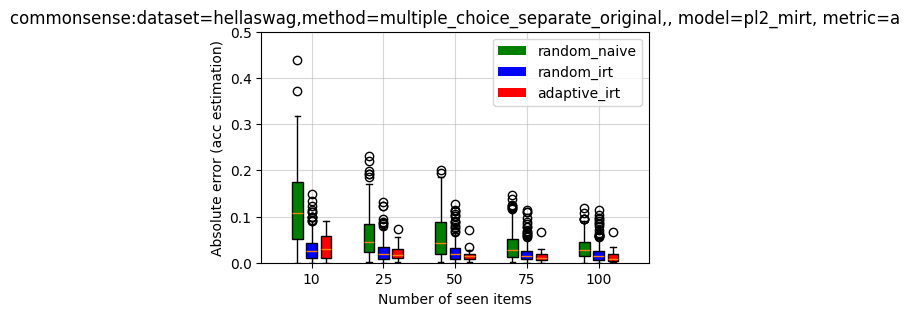

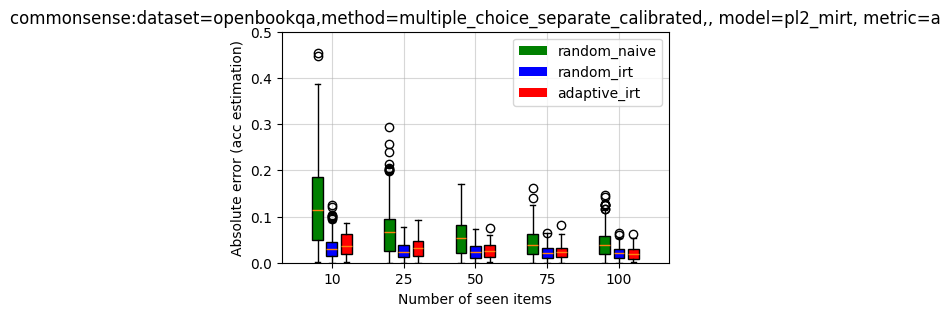

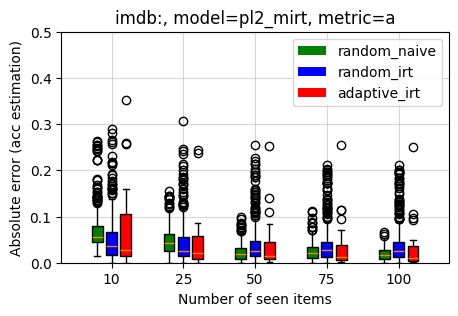

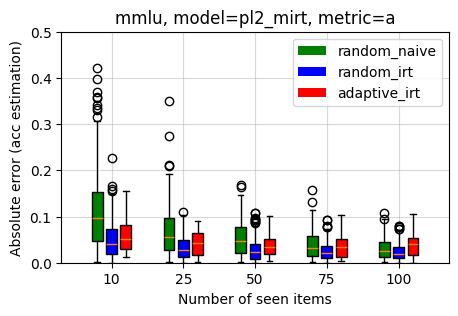

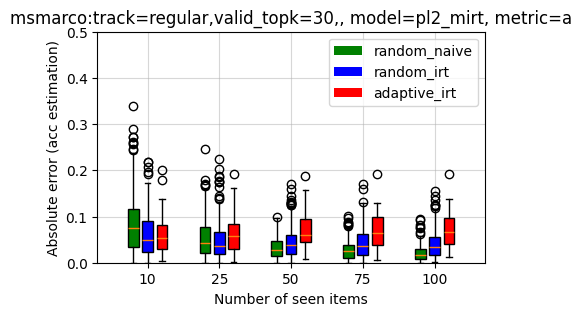

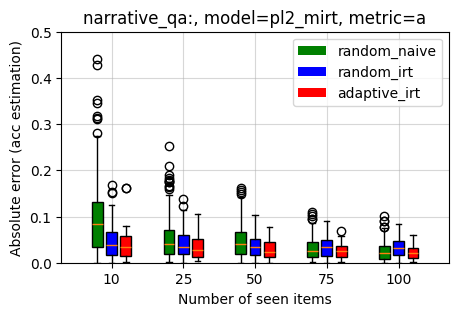

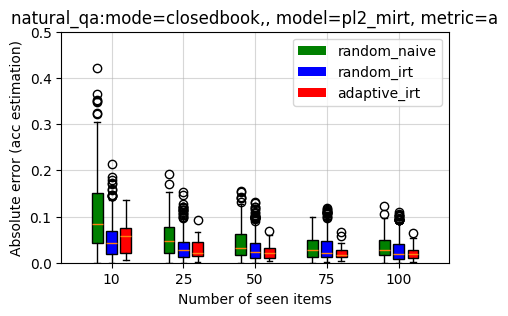

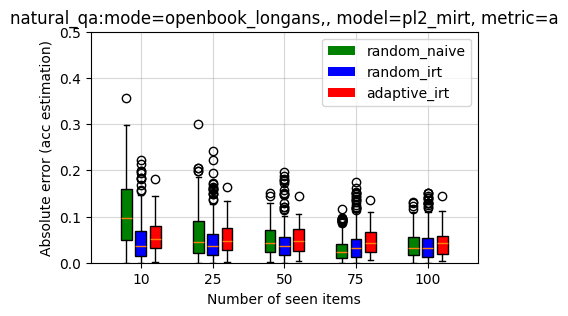

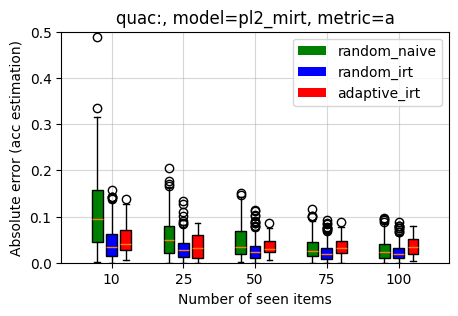

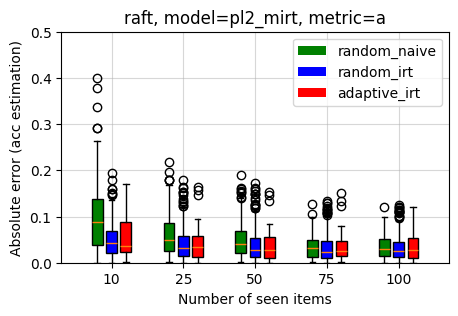

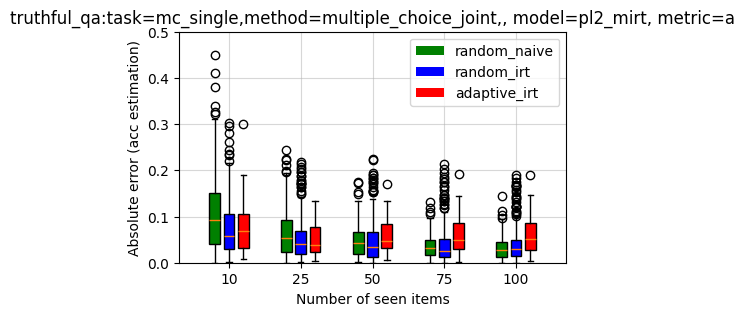

In [5]:
scenario_name = 'full' #scenario
scenarios_choosen = list(scenarios.keys())

accs = {}
results = {}
    
for rows_to_hide in tqdm(set_of_rows):
    rows_to_hide_str = ':'.join([str(r) for r in rows_to_hide])
        
    ### Prep data
    scenarios_position, subscenarios_position = prepare_data(scenarios_choosen, scenarios, data)
    scores = create_responses(scenarios_choosen, scenarios, data)
    scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
    scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
    responses_train = np.zeros(scores_train.shape)
    responses_test = np.zeros(scores_test.shape)

    cs = np.linspace(0.01,.99,1000)
    for scenario in scenarios.keys():
        ind = scenarios_position[scenario]
        c = cs[np.argmin([np.mean((np.abs((scores_train[:,ind]>c).mean(axis=1)-scores_train[:,ind].mean(axis=1)))) for c in cs])]
        responses_train[:,ind] = (scores_train[:,ind]>c).astype(int)
        responses_test[:,ind] = (scores_test[:,ind]>c).astype(int)
        
    ### Choosing D
    train_ind = list(range(0,responses_train.shape[0],2))
    val_ind = [i for i in range(responses_train.shape[0]) if i not in train_ind]
    responses_train[train_ind].shape

    dataset_name = f'data/irt_helm/rows-{rows_to_hide_str}_scenario-{scenario_name}_val_all_models3.jsonlines'
    create_irt_dataset(responses_train[train_ind], dataset_name)

    errors = []
    for D in Ds:
        model_name = f'models/irt_helm/rows-{rows_to_hide_str}_D-{D}_scenario-{scenario_name}_val_all_models3/'
        train_irt_model(dataset_name, model_name, D, hidden, dropout, lr, epochs, device)
        A, B, Theta = load_irt_parameters(model_name)
        seen_items, unseen_items, _ = select_initial_adaptive_items(A, B, Theta, 2*D)
        errors.append(np.median(np.abs(responses_train[val_ind][:,unseen_items].mean(axis=1)-np.array([item_curve(estimate_ability_parameters(r, seen_items, A, B), A, B)[:,unseen_items].mean() for r in responses_train[val_ind]]))))
    D = Ds[np.argmin(errors)]
    print(D,errors)
        
    ### Saving dataset
    dataset_name = f'data/irt_helm/row-{rows_to_hide_str}_scenario-{scenario_name}_all_models3.jsonlines'
    create_irt_dataset(responses_train, dataset_name)

    ### Train final IRT model
    model_name = f'models/irt_helm/row-{rows_to_hide_str}_D-validate_scenario-{scenario_name}_all_models3/'
    train_irt_model(dataset_name, model_name, D, hidden, dropout, lr, epochs, device)

    ### Load IRT model
    A, B, Theta = load_irt_parameters(model_name)
        
    ### Creating storage space in acc and results to store new results
    [create_space_accs_results(accs, results, r, number_items, scenarios_choosen) for r in rows_to_hide]
        
    ### Running adaptive evaluation
    for j in range(len(rows_to_hide)):

        seen_items, unseen_items, mats = select_initial_adaptive_items(A, B, Theta, 2*D) #number_items[0]

        for number_item in number_items:

            # Number of samples
            target_count = len(scenarios_choosen)*number_item

            # Sampling new items  
            seen_items, unseen_items = run_adaptive_selection(responses_test[j], seen_items, unseen_items, scenarios_choosen, scenarios_position, A, B, mats, target_count, balance=balance)

            # Running IRT in the remaining sample 
            new_theta = estimate_ability_parameters(responses_test[j], seen_items, A, B)

            # Updating 'accs' and 'results'
            update_accs_irt('adaptive_irt', scores_test[j], responses_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, seen_items, unseen_items, A, B, new_theta, accs, number_item)
            update_results('adaptive_irt', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, accs, results, number_item)
        
    ### Running random evaluation
    for j in range(len(rows_to_hide)):

        for number_item in number_items:
    
            ### Running with different seeds (ie, different seen_items)
            for it in range(iterations):
                random.seed(random_state*it)
                seen_items, unseen_items = get_seen_unseen_items(scenarios_choosen, scenarios, number_item, subscenarios_position, responses_test)

                ### naive
                # Updating 'accs' 
                update_accs_naive('random_naive', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, seen_items, accs, number_item)

                ### IRT 
                new_theta = estimate_ability_parameters(responses_test[j], seen_items, A, B)

                # Updating 'accs' 
                update_accs_irt('random_irt', scores_test[j], responses_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, seen_items, unseen_items, A, B, new_theta, accs, number_item)

            ### Updating 'results'
            update_results('random_naive', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, accs, results, number_item)
            update_results('random_irt', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, accs, results, number_item)
                
### plots
plot_results(results, scenarios_choosen, number_items, 'a', scenario_name, 'full')

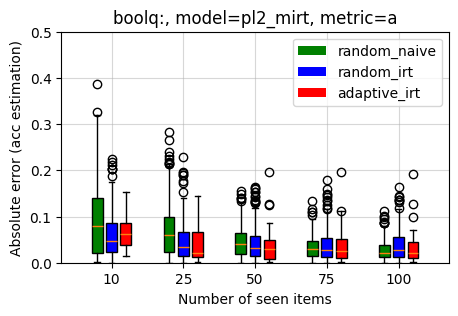

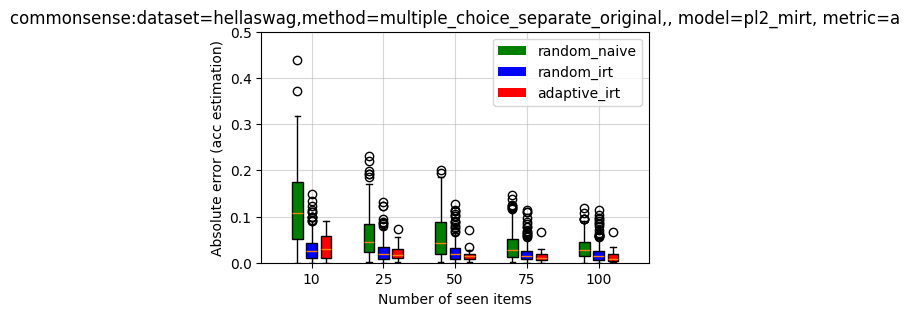

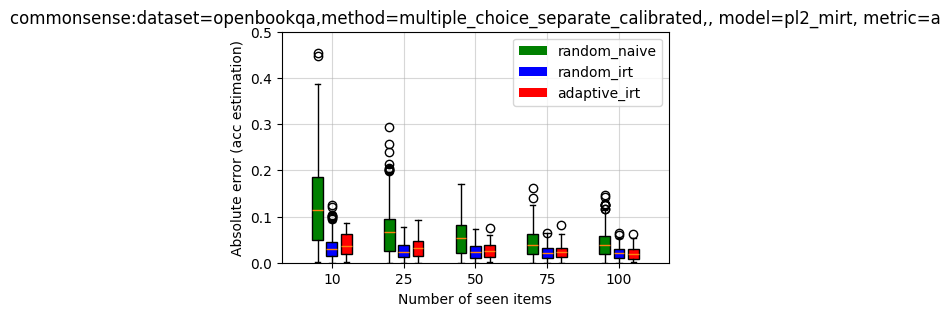

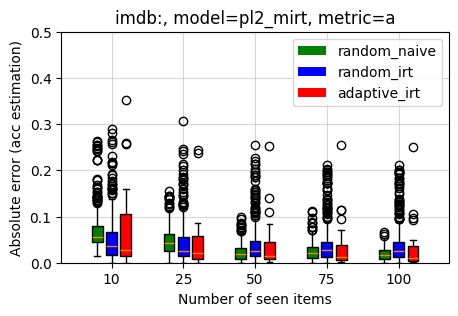

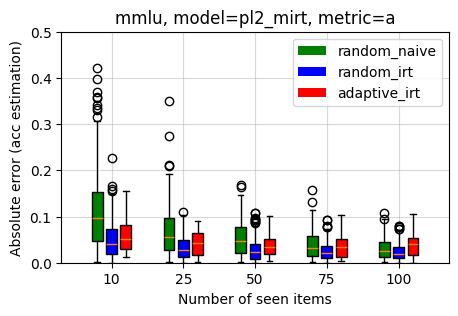

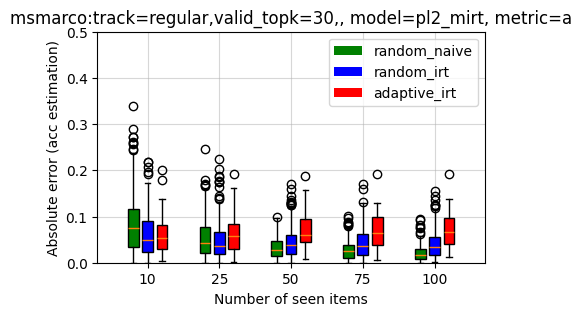

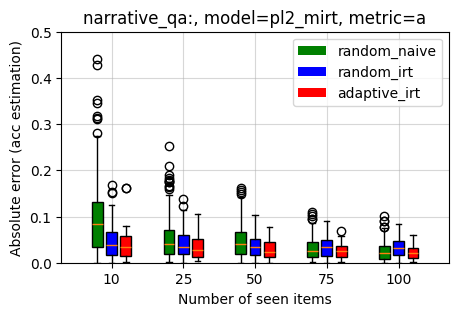

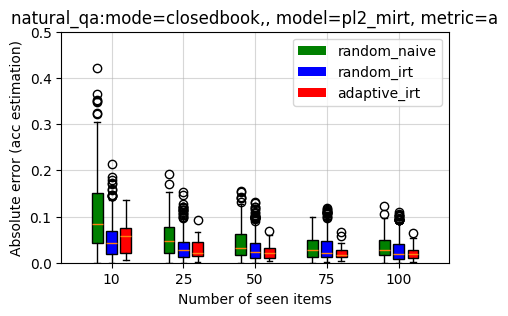

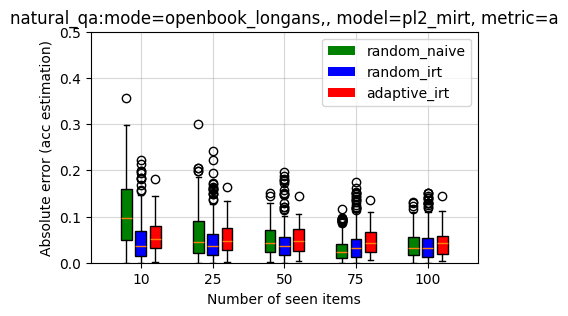

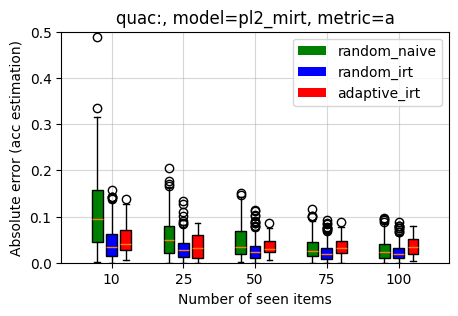

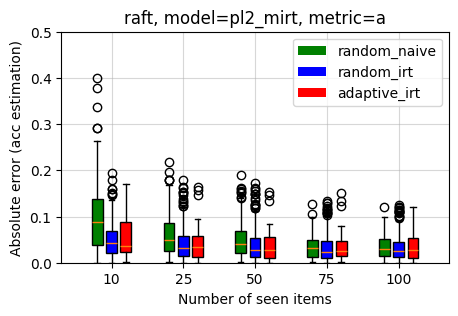

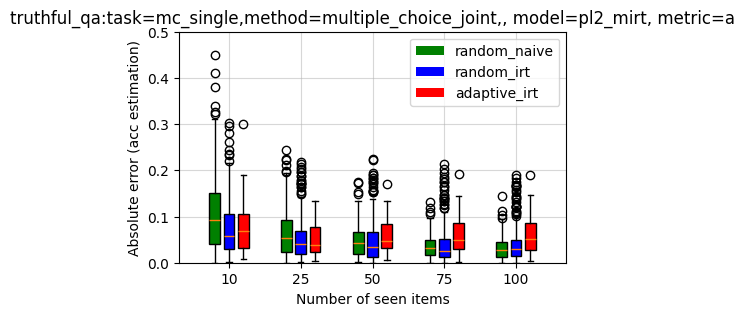

In [6]:
plot_results(results, scenarios_choosen, number_items, 'a', scenario_name, 'full')

In [7]:
import pickle

with open('r4.pickle', 'wb') as handle:
    pickle.dump({'accs':accs, 'res':results}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
methods = ['random_naive', 'random_irt', 'adaptive_irt']

In [9]:
l = scenarios.keys()

In [10]:
cons_results = {}

for scenario in l: 
    for method in methods:
        cons_results[method] = {}
        for number_item in number_items:
            cons_results[method][number_item] = []
            
for scenario in l: 
    for method in methods:
        for number_item in number_items:
            cons_results[method][number_item]+=[np.mean([results[model][number_item][method][scenario] for model in results.keys()])]

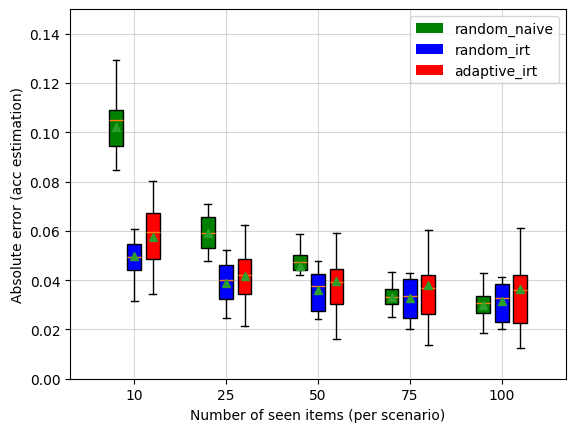

In [14]:
plot_results2(cons_results, number_items, methods)

In [15]:
l = ['boolq:',
     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,',
     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,',
     'imdb:',
     'mmlu',
     #'msmarco:track=regular,valid_topk=30,',
     #'narrative_qa:',
     #'natural_qa:mode=closedbook,',
     #'natural_qa:mode=openbook_longans,',
     #'quac:',
     'raft',
     'truthful_qa:task=mc_single,method=multiple_choice_joint,']

In [16]:
cons_results = {}

for scenario in l: 
    for method in methods:
        cons_results[method] = {}
        for number_item in number_items:
            cons_results[method][number_item] = []
            
for scenario in l: 
    for method in methods:
        for number_item in number_items:
            cons_results[method][number_item]+=[np.mean([results[model][number_item][method][scenario] for model in results.keys()])]

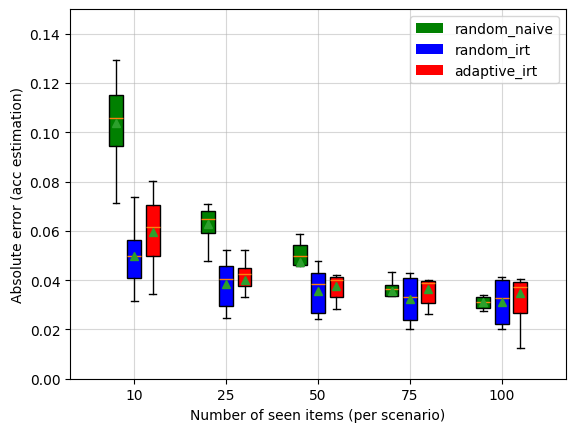

In [17]:
plot_results2(cons_results, number_items, methods)